# Greedy heuristics for the nesting problem
This notebook reports experiments using heuristics for the biscuit optimizer.

In [1]:
# Optimization Project: Biscuit Optimizer
# Roberto Basla
# Politecnico di Milano
# A.Y. 2021/2022

import os
import numpy as np
from pprint import pprint

from typing import Any, Callable
import matplotlib.pyplot as plt
import random
from time import time

import sys
sys.path.append("..")
from utils import utils

## Inputs

In [2]:
images_dir = "../../img/"

In [3]:
image_path = os.path.join(images_dir, "input_dough/input_image.jpg")
bitmask_path = os.path.join(images_dir, "input_dough/input_mask.png")

base_image, bitmask = utils.load_base_image(image_path, bitmask_path)

Subsampled shape: (134, 125)


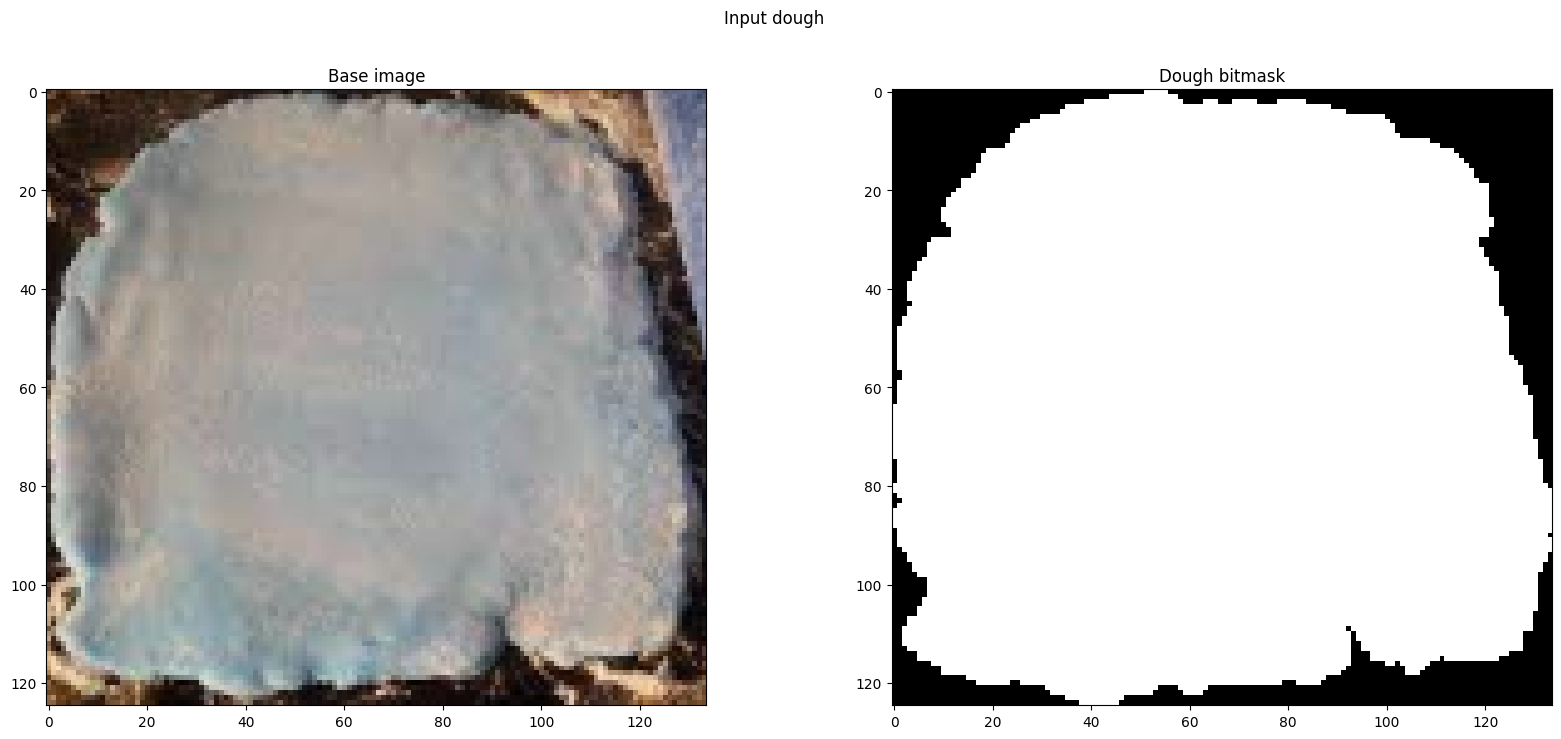

In [4]:
base_image, bitmask = utils.subsample_base_image(base_image, bitmask, resize_factor=0.7, display=True)

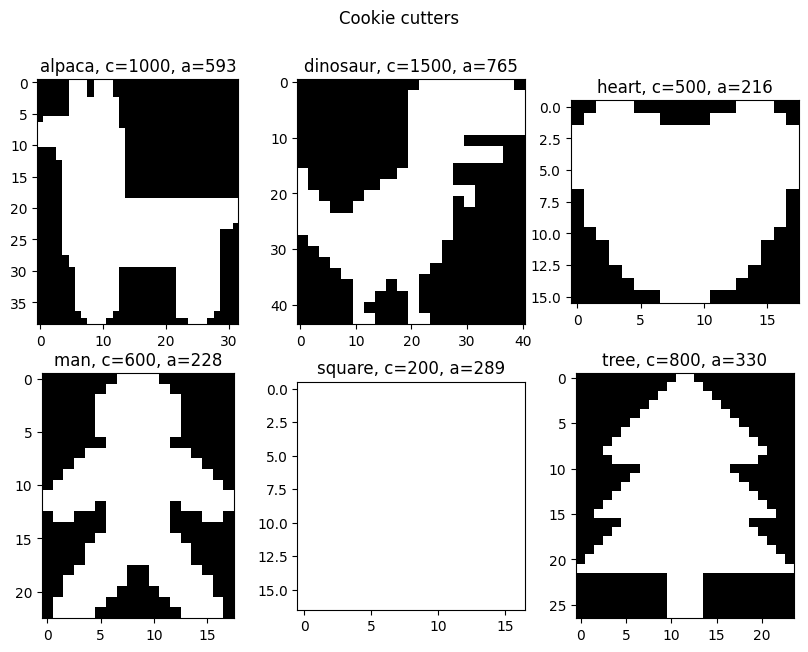

In [5]:
cutters = utils.load_cutters(cutters_path=os.path.join(images_dir, "cutters"), display=True)

## Heuristic process
This section defines the base class for heuristics and the function that applies them. They exploit an occupancy table, i.e. a NumPy array of shape len(I)×N×M containing, for each (i, n, m), the set of variables y that become infeasible if (i, n, m) is selected. 

In [6]:
output_path = "../../img/outputs/greedy"

In [7]:
class Heuristic:
	"""
	Class that, when called, runs the heuristic function and returns a tuple (i, n, m) to add to the current solution 
	"""
	def __init__(self, seed: int = 42):
		self.seed = seed
		random.seed(self.seed)
	
	def place(self, feasible_y: np.array) -> tuple[int, int, int]:
		return -1, -1, -1

	def __call__(self, feasible_y: np.array) -> tuple[int, int, int]:
		return self.place(feasible_y)

In [8]:
occupancy_table = utils.compute_occupancy_table(bitmask, cutters)

In [9]:
def heuristic_place(dough_mask: np.array, cutters: dict[int, dict[str, Any]], place_strategy: Heuristic, 
		show_process: bool = False, process_output: str = None) -> dict[int, list[tuple[int, int]]]:
	"""
	Runs the heuristic on the given mask and cutters using place_strategy
	Args:
		dough_mask: the initial dough binary mask
		cutters: the set of available cutters
		place_strategy: heuristic function
		show_process: if True shows the steps
		process_output: optional path to intermediate images output
	Returns
		solution: the dictionary of the solution
	"""

	# Solution initialization
	solution = {i: [] for i in range(len(cutters))}

	# Inputs initialization
	if show_process or process_output is not None:
		previous_mask = np.copy(dough_mask)
		available_mask = utils.mask_usable(dough_mask, cutters)
	feasible_y = utils.compute_feasible_y(dough_mask, cutters)
	count = 1
	# The heuristic goes on until the dough_mask is empty or no cutter can be placed 
	while np.count_nonzero(feasible_y) > 0:
		if show_process or process_output is not None:
			# Solution tracking for gif generation
			plt.figure(figsize=(5, 5))
			waste = np.logical_xor(previous_mask, available_mask)
			plt.imshow(np.where(waste, 0.5, available_mask), cmap="cividis")
			plt.axis("off")
			if show_process:
				plt.show()
			else:
				plt.savefig(process_output + f"/{count}.png", dpi=200)
			count += 1
		
		# Removes from feasible_cutters those that, if placed, would break the frequency constraints
		corrected_y = np.copy(feasible_y)
		min_placed = min([len(nm) for nm in solution.values()])
		for i in range(len(cutters)):
			if len(solution[i]) > 0 and len(solution[i]) >= 3 * min_placed:
				corrected_y[i] = np.zeros_like(dough_mask)

		if np.count_nonzero(corrected_y) == 0:
			break
		# Calls the strategy on the current mask and feasible cutters
		i, n, m = place_strategy(corrected_y)
		# Updates the solution and the remaining mask
		solution[i].append((n, m))
		feasible_y = utils.update_feasible_y(feasible_y, occupancy_table, cutters, i, n, m)
		if show_process or process_output is not None:
			cutter_mask = cutters[i]["mask"]
			available_mask[n:n+cutter_mask.shape[0], m:m+cutter_mask.shape[1]] = \
				np.logical_and(available_mask[n:n+cutter_mask.shape[0], m:m+cutter_mask.shape[1]], np.logical_not(cutter_mask))
			previous_mask = available_mask
			available_mask = utils.mask_usable(available_mask, cutters)
	
	return solution

In [10]:
def show_heuristic_example(base_image: np.array, bitmask: np.array, cutters: dict[int, dict[str, Any]], 
		strategy: Callable, show_process: bool = False, title: str = None):
	"""
	Computes and displays the result of an heuristic
	"""
	start = time()
	solution = heuristic_place(bitmask, cutters, strategy, show_process)
	print("Solution time:", round(time() - start, 2), "s")
	cutter_masks = {i: cutter["mask"] for i, cutter in enumerate(cutters)}
	pprint(solution)
	value = sum([len(solution[i]) * cutters[i]["value"] for i in solution])
	if title is None:
		title = "Heuristic"
	utils.show_cut_dough(base_image, cutter_masks, solution, f"{title} solution - value={value}")

### Cost functions
These functions define the objective value to be minimized used by the heuristics. Cost maps that appear uniform define a different cost only over the cutter $i$.

#### Value-based cost function
Heuristics using this cost function minimize the negative value of the placed cutters (equivalent to maximizing their value) and corresponds to the usual objective function

Shape: (6, 125, 134) Min: -1500 Max: -200
(Flattened) Shape: (125, 134) Min: -4600 Max: -4600
(Layer 0) Shape: (125, 134) Min: -1000 Max: -1000


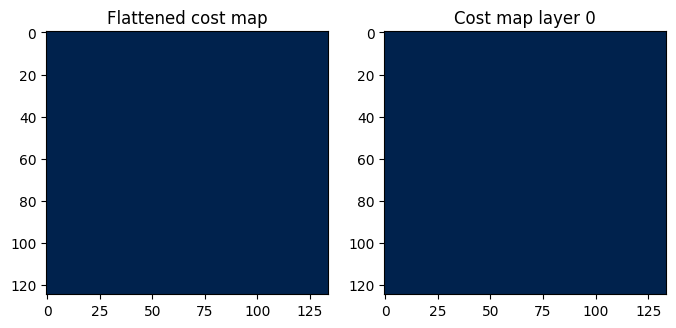

In [11]:
value_cost_map = utils.compute_value_cost(bitmask, cutters)
print("Shape:", value_cost_map.shape, "Min:", np.min(value_cost_map), "Max:", np.max(value_cost_map))
utils.show_cost_map(value_cost_map)

#### Area-based cost function
Heuristics using this cost function minimize the area cost of biscuits.

Shape: (6, 125, 134) Min: 216 Max: 765
(Flattened) Shape: (125, 134) Min: 2421 Max: 2421
(Layer 0) Shape: (125, 134) Min: 593 Max: 593


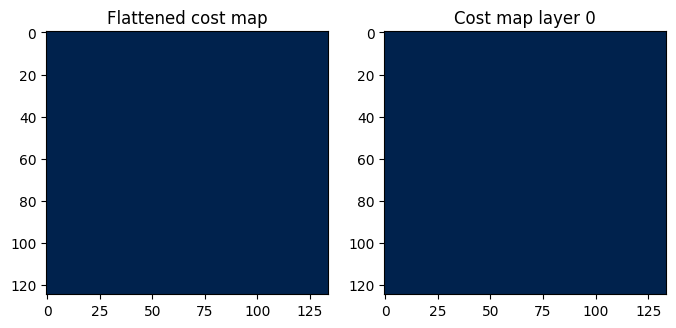

In [12]:
area_cost_map = utils.compute_area_cost(bitmask, cutters)
print("Shape:", area_cost_map.shape, "Min:", np.min(area_cost_map), "Max:", np.max(area_cost_map))
utils.show_cost_map(area_cost_map)

#### Occupancy-based cost function
This cost function tries to minimize the number of ys that are made infeasible by a placement.

Shape: (6, 125, 134) Min: 0.0 Max: 184.4695
(Flattened) Shape: (125, 134) Min: 0.0 Max: 584.8342
(Layer 0) Shape: (125, 134) Min: 0.0 Max: 143.4441


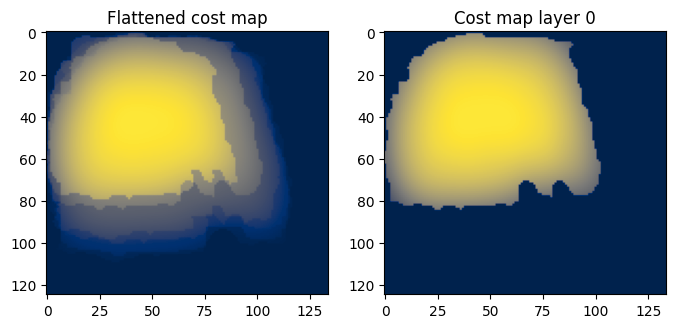

In [13]:
occupancy_cost_map = utils.compute_occupancy_cost(bitmask, cutters, occupancy_table)
print("Shape:", occupancy_cost_map.shape, "Min:", np.min(occupancy_cost_map), "Max:", np.max(occupancy_cost_map))
utils.show_cost_map(occupancy_cost_map)

#### Composite cost functions
These cost functions compose the previous ones

Shape: (6, 125, 134) Min: -2.6315789473684212 Max: -0.6920415224913494
(Flattened) Shape: (125, 134) Min: -11.709802663451942 Max: -11.709802663451942
(Layer 0) Shape: (125, 134) Min: -1.6863406408094435 Max: -1.6863406408094435


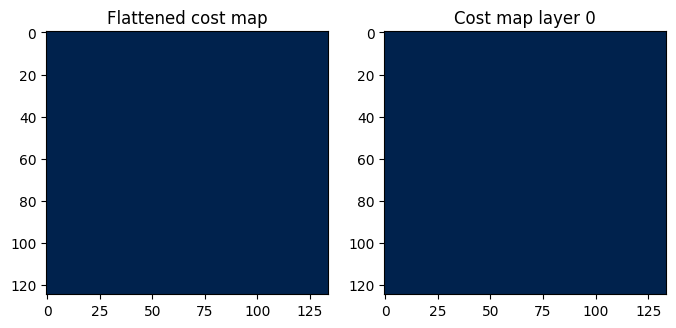

In [14]:
value_area_cost_map = value_cost_map / area_cost_map
print("Shape:", value_area_cost_map.shape, "Min:", np.min(value_area_cost_map), 
	"Max:", np.max(value_area_cost_map))
utils.show_cost_map(value_area_cost_map)

Shape: (6, 125, 134) Min: -1500.0 Max: -2.818215252462768
(Flattened) Shape: (125, 134) Min: -4600.0 Max: -47.80734657436029
(Layer 0) Shape: (125, 134) Min: -1000.0 Max: -6.92309343199203


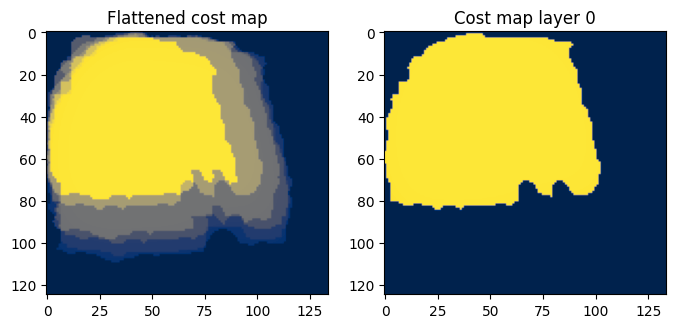

In [15]:
value_occupancy_cost_map = value_cost_map / (occupancy_cost_map + 1)
print("Shape:", value_occupancy_cost_map.shape, "Min:", np.min(value_occupancy_cost_map), 
	"Max:", np.max(value_occupancy_cost_map))
utils.show_cost_map(value_occupancy_cost_map)

Shape: (6, 125, 134) Min: 216.0 Max: 141884.1675
(Flattened) Shape: (125, 134) Min: 2421.0 Max: 298905.74679999996
(Layer 0) Shape: (125, 134) Min: 593.0 Max: 85655.3513


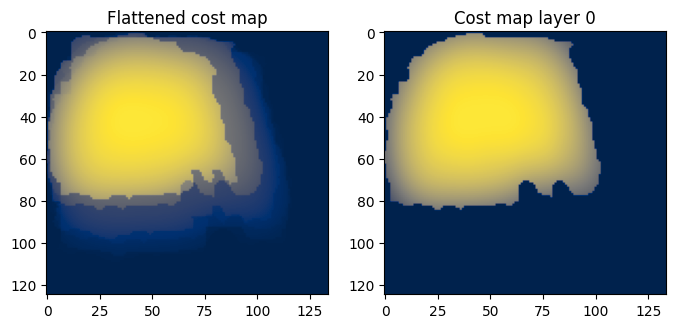

In [16]:
area_occupancy_cost_map = (occupancy_cost_map + 1) * area_cost_map
print("Shape:", area_occupancy_cost_map.shape, "Min:", np.min(area_occupancy_cost_map), 
	"Max:", np.max(area_occupancy_cost_map))
utils.show_cost_map(area_occupancy_cost_map)

## Heuristic strategies


### Random strategy
The random strategy chooses randomly one of the feasible ys at each step

In [17]:
class RandomStrategy(Heuristic):
	"""
	Strategy selecting random available ys
	"""
	def place(self, feasible_y):
		i, n, m = random.choice(np.argwhere(feasible_y))
		return i, n, m
random_strategy = RandomStrategy()

Solution time: 2.72 s
{0: [(42, 29)],
 1: [(16, 45)],
 2: [(94, 48), (84, 8), (63, 97)],
 3: [(49, 74), (41, 10), (13, 37)],
 4: [(101, 11), (71, 58), (16, 17)],
 5: [(24, 80), (84, 103), (75, 75)]}


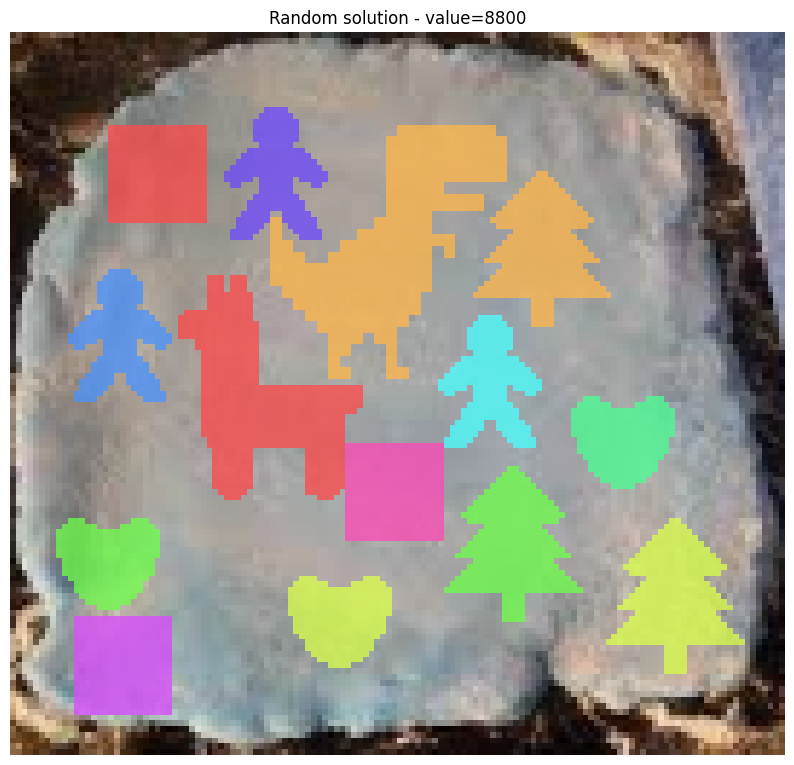

In [18]:
show_heuristic_example(base_image, bitmask, cutters, random_strategy, title="Random")

### Greedy/random strategy
This strategy chooses greedily the cutter but randomly the position

In [19]:
class GreedyRandomStrategy(Heuristic):
	"""
	Strategy selecting greedily the cutter and randomly the position
	"""
	def __init__(self, cutters, seed: int = 42):
		super().__init__(seed)
		self.greedy_values = np.array([cutter["value"] for cutter in cutters])

	def place(self, feasible_y):
		i = np.argmax(np.count_nonzero(feasible_y, axis=(1, 2)).astype(bool) * self.greedy_values)
		n, m = random.choice(np.argwhere(feasible_y[i]))
		return i, n, m
greedy_random_strategy = GreedyRandomStrategy(cutters)

Solution time: 3.11 s
{0: [(16, 23), (16, 58), (80, 10)],
 1: [(71, 61), (62, 32)],
 2: [(53, 74), (57, 102), (66, 1)],
 3: [(55, 29), (14, 96), (1, 41)],
 4: [(40, 103)],
 5: [(6, 72), (39, 5), (81, 100)]}


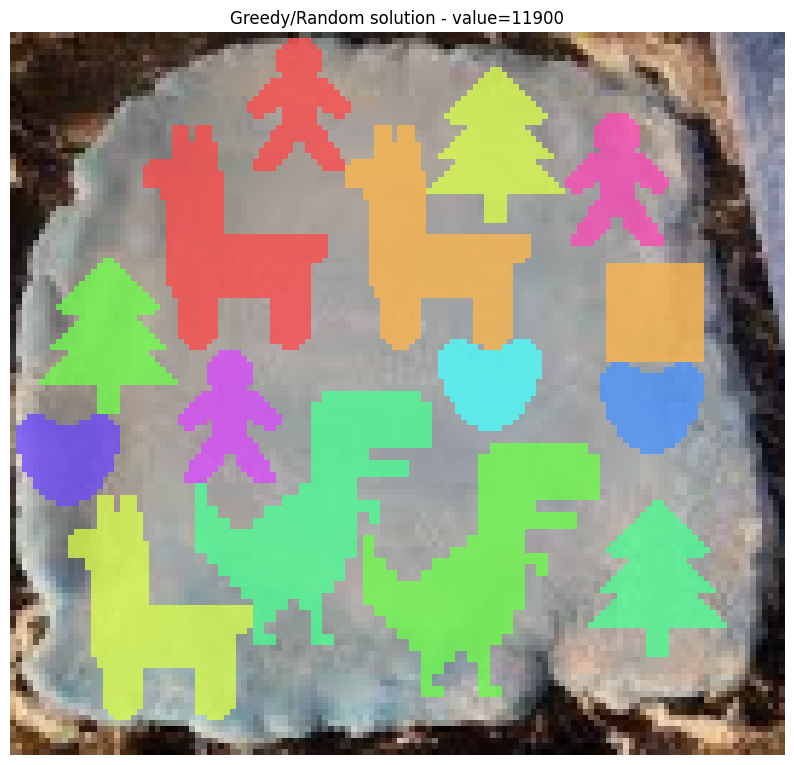

In [20]:
show_heuristic_example(base_image, bitmask, cutters, greedy_random_strategy, title="Greedy/Random")

### Greedy strategy
This strategy chooses greedily at each step from the set of feasible ys

In [21]:
class GreedyStrategy(Heuristic):
	"""
	Greedy strategy minimizing the total cost given from the cost_map
	"""
	def __init__(self, cost_map, seed: int = 42):
		super().__init__(seed)
		self.cost_map = cost_map

	def place(self, feasible_y):
		mapped_feasible = np.where(feasible_y, self.cost_map, 0) 
		best = np.min(mapped_feasible[mapped_feasible != 0])
		i, n, m = random.choice(np.argwhere(mapped_feasible == best))
		return i, n, m

greedy_value_strategy = GreedyStrategy(value_cost_map)
greedy_area_strategy = GreedyStrategy(area_cost_map)
greedy_occupancy_strategy = GreedyStrategy(occupancy_cost_map)

greedy_value_area_strategy = GreedyStrategy(value_area_cost_map)
greedy_value_occupancy_strategy = GreedyStrategy(value_occupancy_cost_map)
greedy_area_occupancy_strategy = GreedyStrategy(area_occupancy_cost_map)

Solution time: 3.61 s
{0: [(16, 23), (16, 58), (80, 10)],
 1: [(71, 61), (62, 32)],
 2: [(53, 74), (57, 102), (66, 1)],
 3: [(55, 29), (14, 96), (1, 41)],
 4: [(40, 103)],
 5: [(6, 72), (39, 5), (81, 100)]}


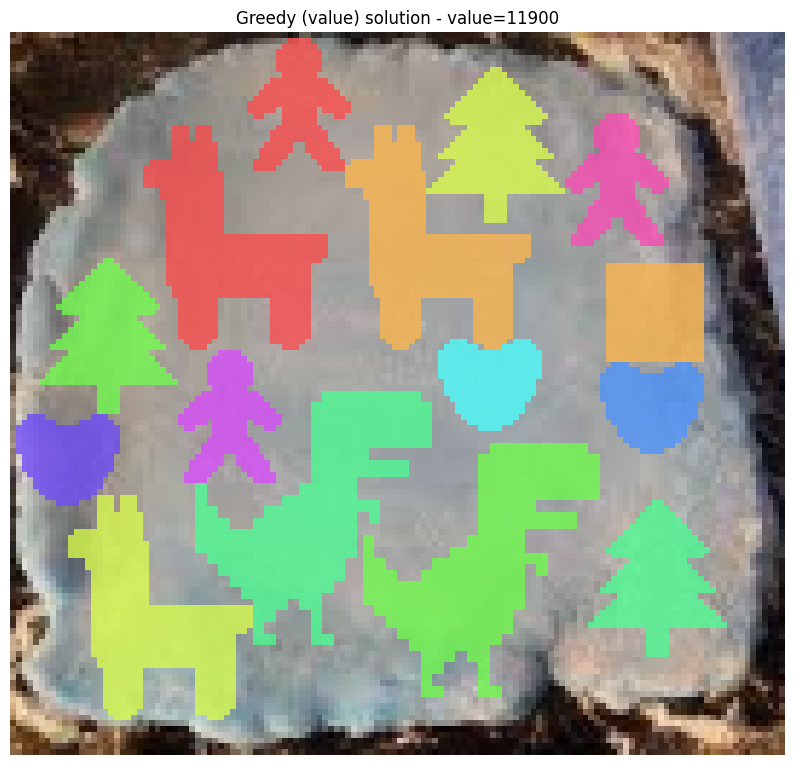

In [22]:
show_heuristic_example(base_image, bitmask, cutters, greedy_value_strategy, title="Greedy (value)")

Solution time: 2.76 s
{0: [(3, 62)],
 1: [(62, 3)],
 2: [(44, 21), (25, 95), (91, 92)],
 3: [(51, 103), (84, 66), (16, 46)],
 4: [(64, 63), (66, 87), (46, 75)],
 5: [(89, 28), (16, 20), (35, 43)]}


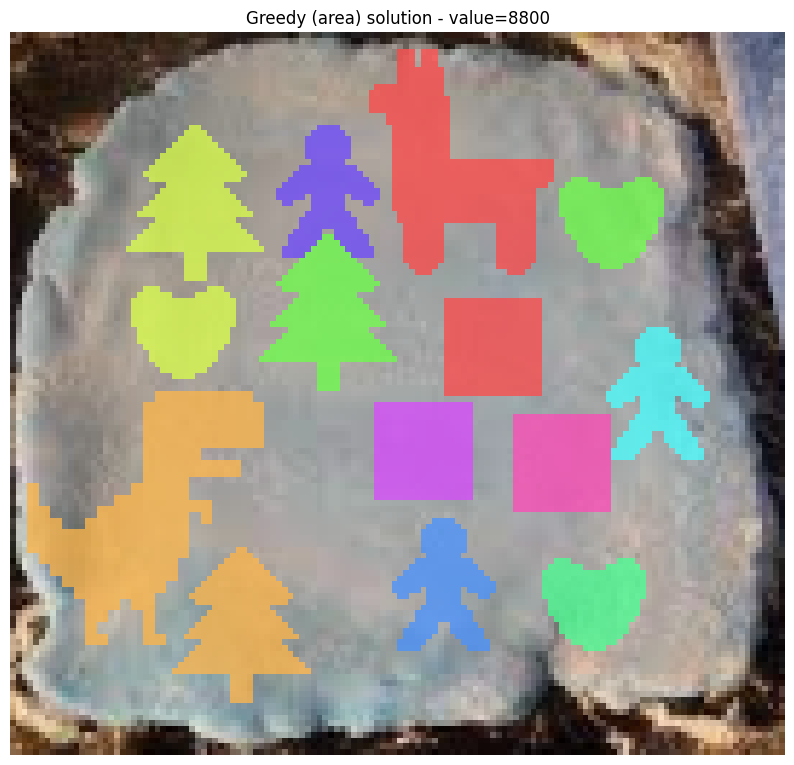

In [23]:
show_heuristic_example(base_image, bitmask, cutters, greedy_area_strategy, title="Greedy (area)")

Solution time: 3.29 s
{0: [(62, 0), (30, 79), (34, 19)],
 1: [(67, 89), (57, 32)],
 2: [(100, 112), (104, 74), (109, 31), (19, 31), (88, 71), (71, 91)],
 3: [(12, 103), (37, 1), (35, 107), (19, 46), (67, 65), (31, 63)],
 4: [(102, 10), (5, 83), (2, 39)],
 5: [(12, 10), (96, 49), (2, 61)]}


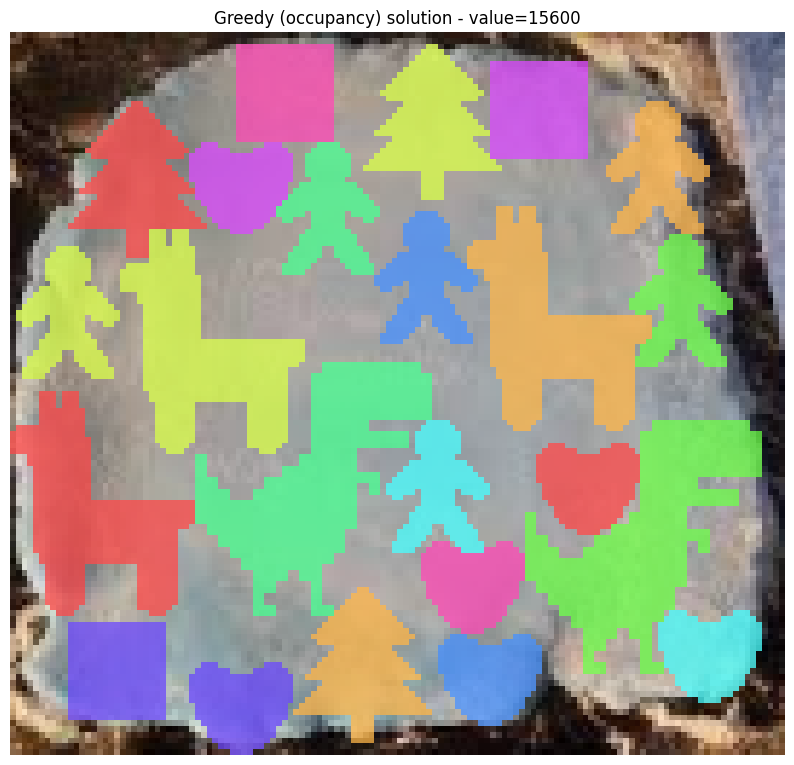

In [24]:
show_heuristic_example(base_image, bitmask, cutters, greedy_occupancy_strategy, title="Greedy (occupancy)")

Solution time: 2.66 s
{0: [(78, 6)],
 1: [(7, 35)],
 2: [(68, 97), (81, 113), (93, 98)],
 3: [(12, 99), (90, 56), (25, 12)],
 4: [(60, 1), (41, 65), (21, 79)],
 5: [(48, 28), (40, 84), (60, 54)]}


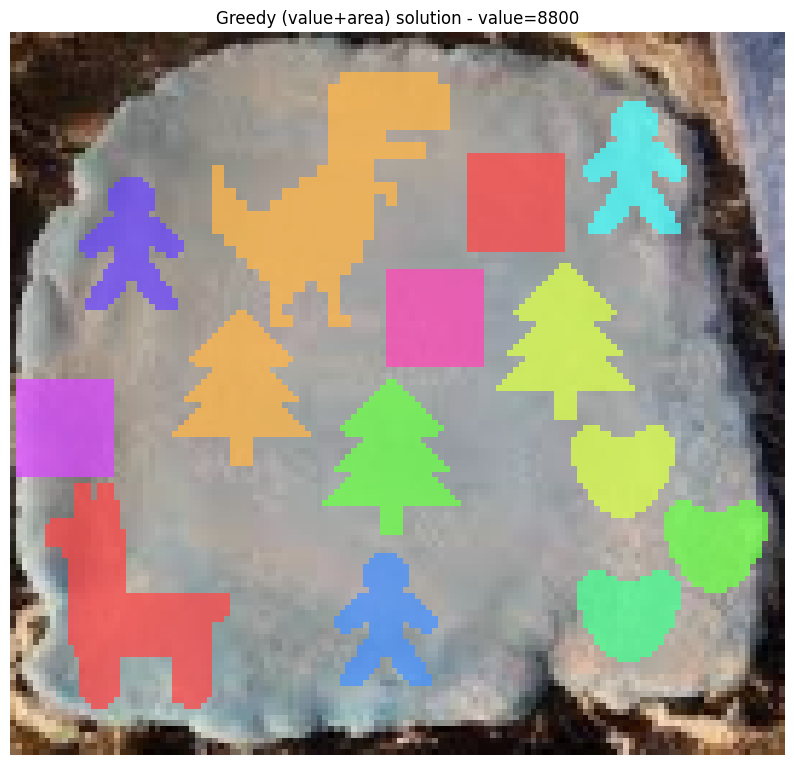

In [25]:
show_heuristic_example(base_image, bitmask, cutters, greedy_value_area_strategy, title="Greedy (value+area)")

Solution time: 3.7 s
{0: [(58, 0), (61, 84)],
 1: [(3, 14), (3, 50), (66, 29)],
 2: [(100, 112), (100, 92), (109, 31), (35, 74), (70, 31), (56, 31)],
 3: [(12, 103), (70, 116), (30, 3), (52, 13), (79, 71), (35, 89)],
 4: [(102, 74), (18, 86), (51, 68)],
 5: [(92, 4), (39, 104), (96, 49), (29, 35)]}


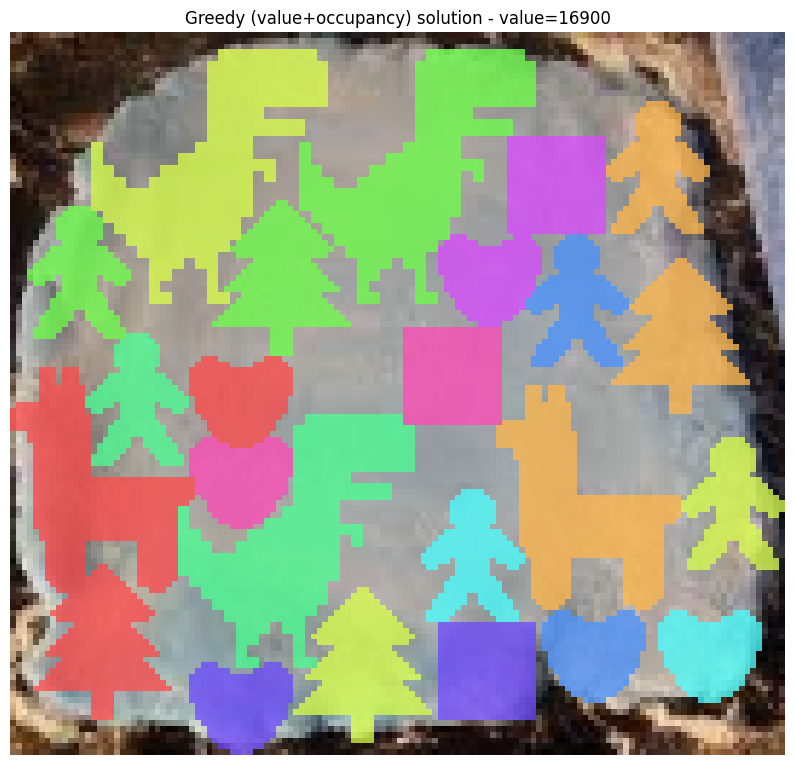

In [26]:
show_heuristic_example(base_image, bitmask, cutters, greedy_value_occupancy_strategy, title="Greedy (value+occupancy)")

Solution time: 3.34 s
{0: [(62, 0), (30, 79), (34, 19)],
 1: [(67, 89), (57, 32)],
 2: [(100, 112), (104, 74), (109, 31), (19, 31), (88, 71), (71, 91)],
 3: [(12, 103), (37, 1), (35, 107), (19, 46), (67, 65), (31, 63)],
 4: [(102, 10), (5, 83), (2, 39)],
 5: [(12, 10), (96, 49), (2, 61)]}


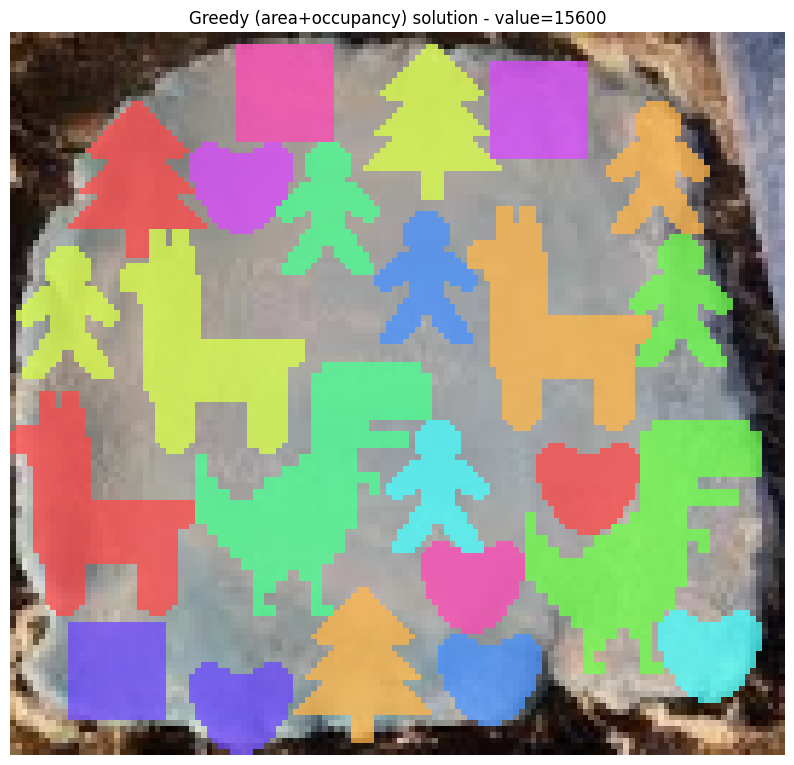

In [27]:
show_heuristic_example(base_image, bitmask, cutters, greedy_area_occupancy_strategy, title="Greedy (area+occupancy)")

## Tests

In [28]:
n_tests = 100

In [77]:
def show_test_results(values_dict: dict[int, int], title: str = None):
	"""
	Displays the distribution of results of in values_dict
	Args:
		values_dict: Dictionary of result: frequency
		title: Title of the plot
	"""
	print("Average value:", sum(v * n for v, n in values_dict.items()) / n_tests)
	plt.figure(figsize=(10, 7))
	plt.bar(values_dict.keys(), values_dict.values(), width=50)
	if title is None:
		title = "Heuristics"
	plt.title(f"{title} - {n_tests} simulations")
	plt.xlabel("Final value")
	plt.ylabel("Frequency")
	plt.show()

def show_all_results(results_dict: dict[str, dict[int, int]]):
	"""
	Displays the distribution of results of all different strategies in results_dict
	Args:
		results_dict: Dictionary of label: result
	"""
	plt.figure(figsize=(15, 10))
	labels = []
	shift = -30
	for title, results in results_dict.items():
		plt.bar(np.array(list(results.keys())) + shift, results.values(), width=40)
		labels.append(title)
		shift += 15

	plt.legend(labels=labels)
	plt.xlabel("Final value")
	plt.ylabel("Frequency")
	plt.show()

In [36]:
def perform_test(strategy: Heuristic, n_tests: int):
	"""
	Performs n_tests simulations of the given strategy
	Args:
		strategy: The heuristic to test
		n_tests: number of tests to perform
	"""
	values = {}
	start = time()
	for i in range(n_tests):
		solution = heuristic_place(bitmask, cutters, strategy)
		solution = {i: solution[name] for i, name in enumerate(solution.keys())}
		value = sum([len(solution[i]) * cutters[i]["value"] for i in solution.keys()])
		try:
			values[value] += 1
		except KeyError:
			values[value] = 1
	print(f"Time for {n_tests} simulations:", round(time() - start, 2), "s")
	return values

Time for 100 simulations: 277.8 s
{8000: 1, 8800: 68, 9800: 26, 10300: 4, 12700: 1}
Average value: 9151.0


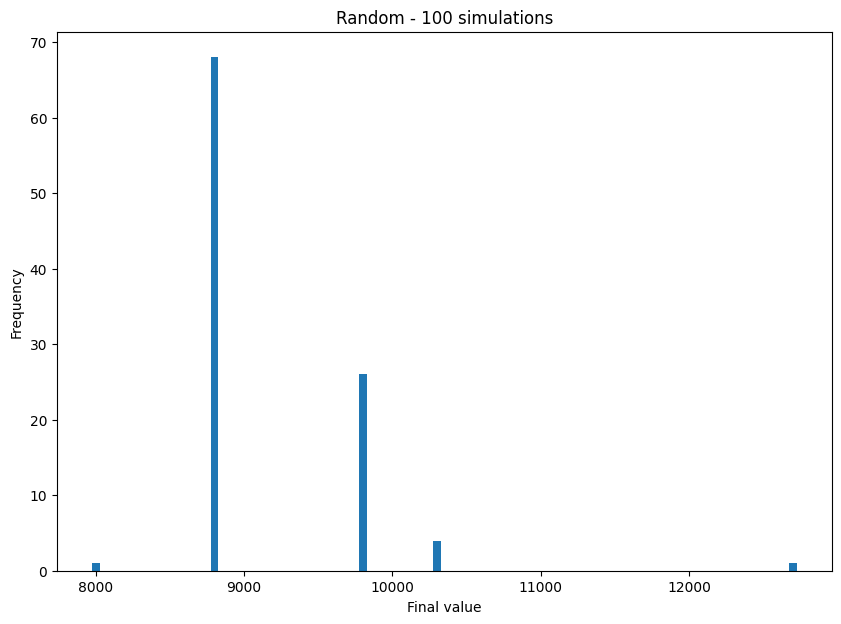

In [37]:
random_dict = perform_test(random_strategy, n_tests)
pprint(random_dict)
show_test_results(random_dict, "Random")

Time for 100 simulations: 331.79 s
{10800: 5,
 11600: 4,
 11800: 5,
 11900: 2,
 12200: 1,
 12400: 7,
 12600: 3,
 12800: 1,
 13100: 1,
 13200: 4,
 13300: 2,
 13400: 8,
 13500: 1,
 13600: 7,
 13700: 6,
 13800: 3,
 13900: 2,
 14000: 1,
 14100: 5,
 14200: 3,
 14300: 2,
 14400: 3,
 14600: 4,
 14700: 6,
 14800: 5,
 14900: 4,
 15000: 1,
 15300: 1,
 15400: 1,
 15600: 1,
 15900: 1}
Average value: 13489.0


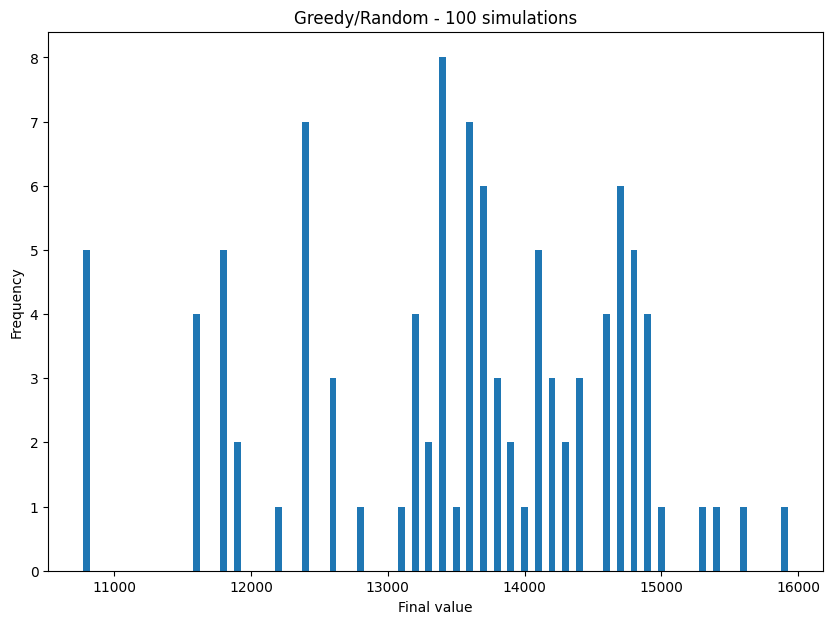

In [38]:
greedy_random_dict = perform_test(greedy_random_strategy, n_tests)
pprint(greedy_random_dict)
show_test_results(greedy_random_dict, "Greedy/Random")

Time for 100 simulations: 334.69 s
{10300: 1,
 10800: 2,
 11400: 1,
 11600: 2,
 11800: 16,
 11900: 3,
 12400: 10,
 12900: 1,
 13200: 6,
 13400: 11,
 13600: 7,
 13700: 6,
 13800: 4,
 13900: 1,
 14000: 2,
 14100: 4,
 14200: 5,
 14400: 2,
 14500: 1,
 14600: 1,
 14700: 5,
 14800: 1,
 15100: 3,
 15300: 2,
 15400: 2,
 15600: 1}
Average value: 13249.0


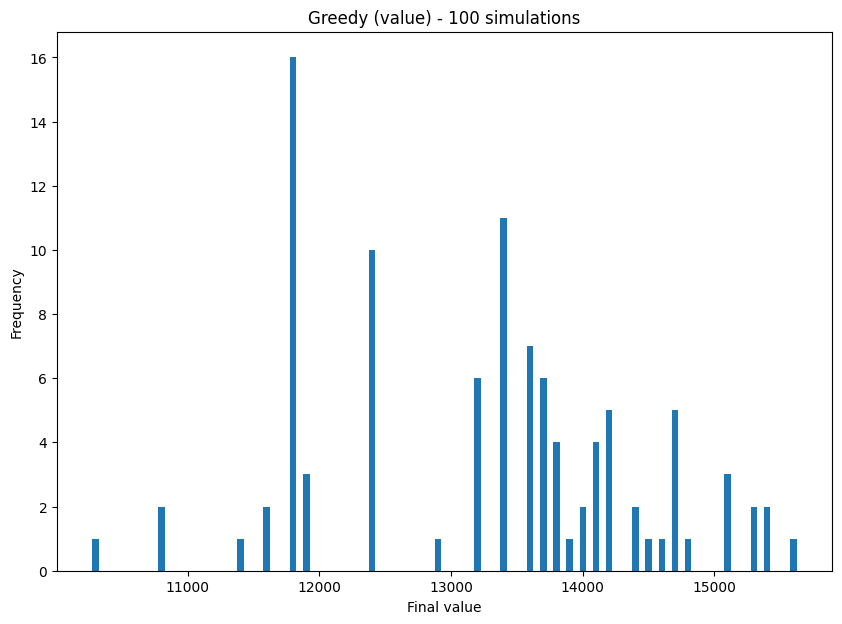

In [39]:
greedy_value_dict = perform_test(greedy_value_strategy, n_tests)
pprint(greedy_value_dict)
show_test_results(greedy_value_dict, "Greedy (value)")

Time for 100 simulations: 260.93 s
{8800: 80, 9800: 20}
Average value: 9000.0


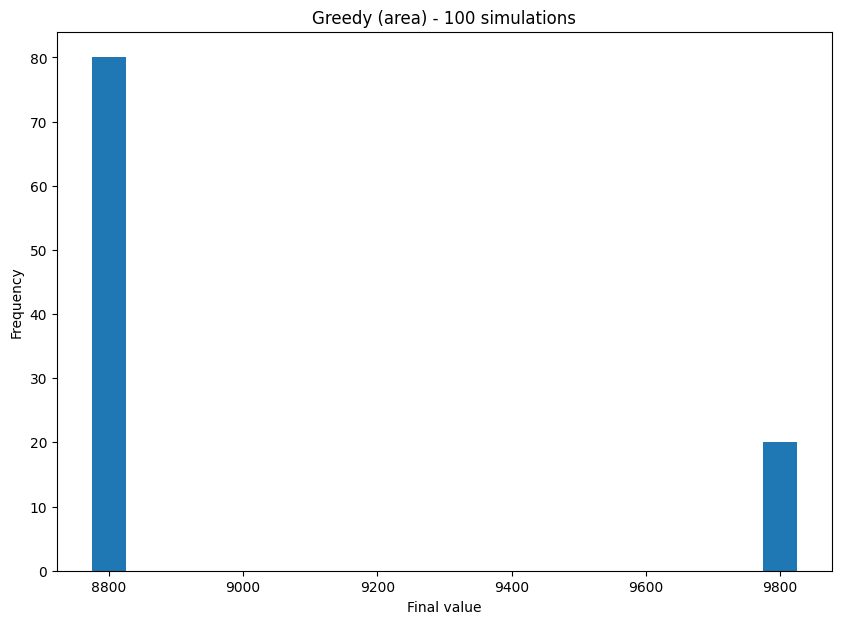

In [40]:
greedy_area_dict = perform_test(greedy_area_strategy, n_tests)
pprint(greedy_area_dict)
show_test_results(greedy_area_dict, "Greedy (area)")

Time for 100 simulations: 329.51 s
{15600: 100}
Average value: 15600.0


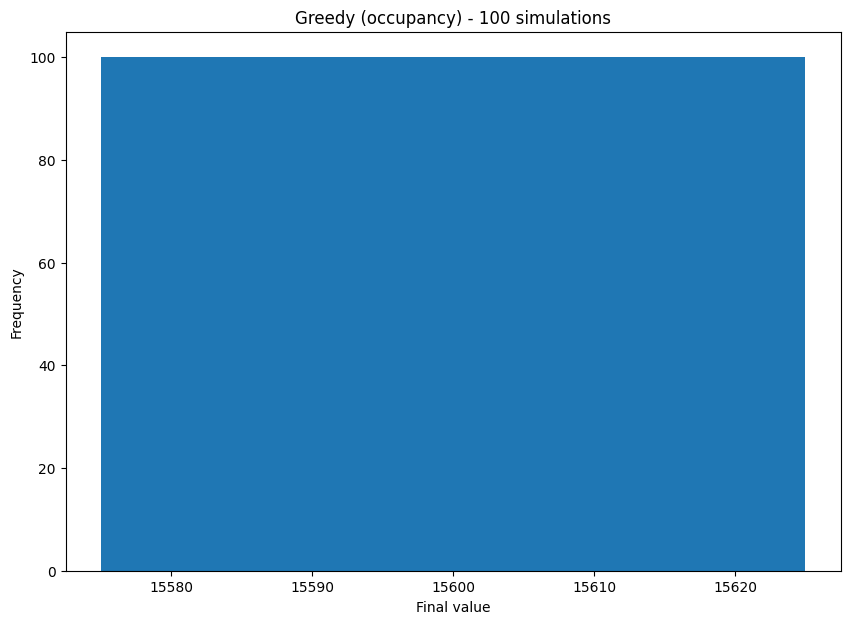

In [41]:
greedy_occupancy_dict = perform_test(greedy_occupancy_strategy, n_tests)
pprint(greedy_occupancy_dict)
show_test_results(greedy_occupancy_dict, "Greedy (occupancy)")

Time for 100 simulations: 258.44 s
{8800: 45, 9800: 32, 10300: 12, 10800: 9, 11800: 1, 13300: 1}
Average value: 9555.0


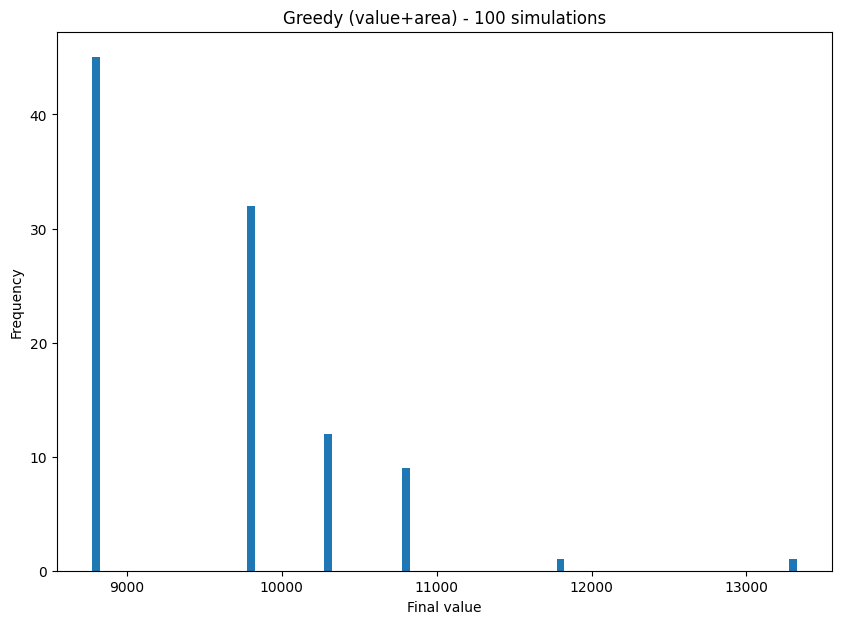

In [42]:
greedy_value_area_dict = perform_test(greedy_value_area_strategy, n_tests)
pprint(greedy_value_area_dict)
show_test_results(greedy_value_area_dict, "Greedy (value+area)")

Time for 100 simulations: 353.11 s
{16900: 100}
Average value: 16900.0


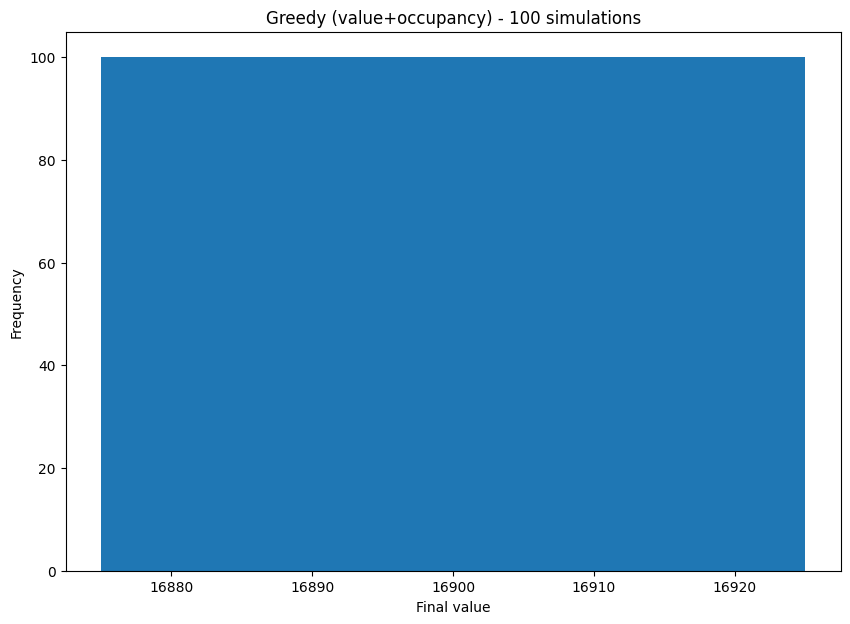

In [43]:
greedy_value_occupancy_dict = perform_test(greedy_value_occupancy_strategy, n_tests)
pprint(greedy_value_occupancy_dict)
show_test_results(greedy_value_occupancy_dict, "Greedy (value+occupancy)")

Time for 100 simulations: 328.72 s
{15600: 100}
Average value: 15600.0


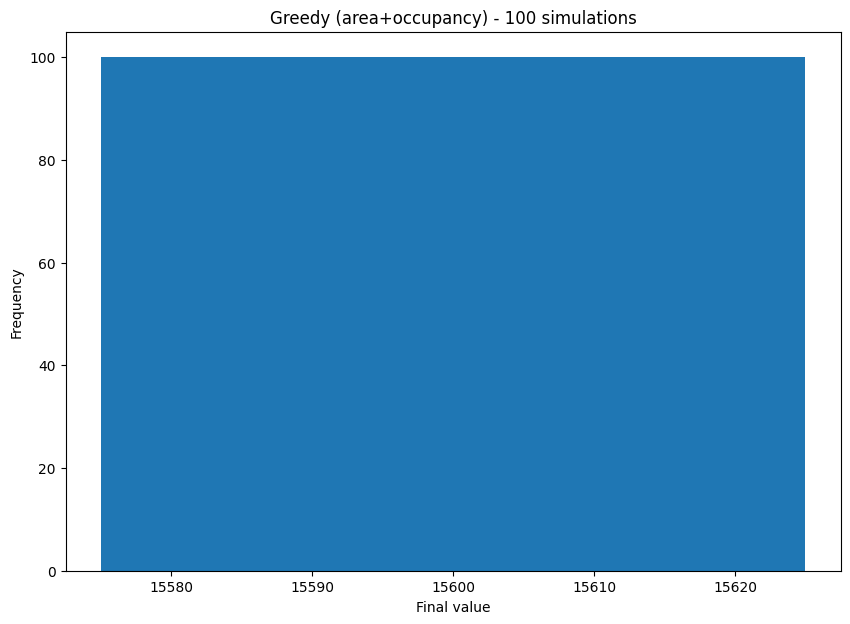

In [44]:
greedy_area_occupancy_dict = perform_test(greedy_area_occupancy_strategy, n_tests)
pprint(greedy_area_occupancy_dict)
show_test_results(greedy_area_occupancy_dict, "Greedy (area+occupancy)")

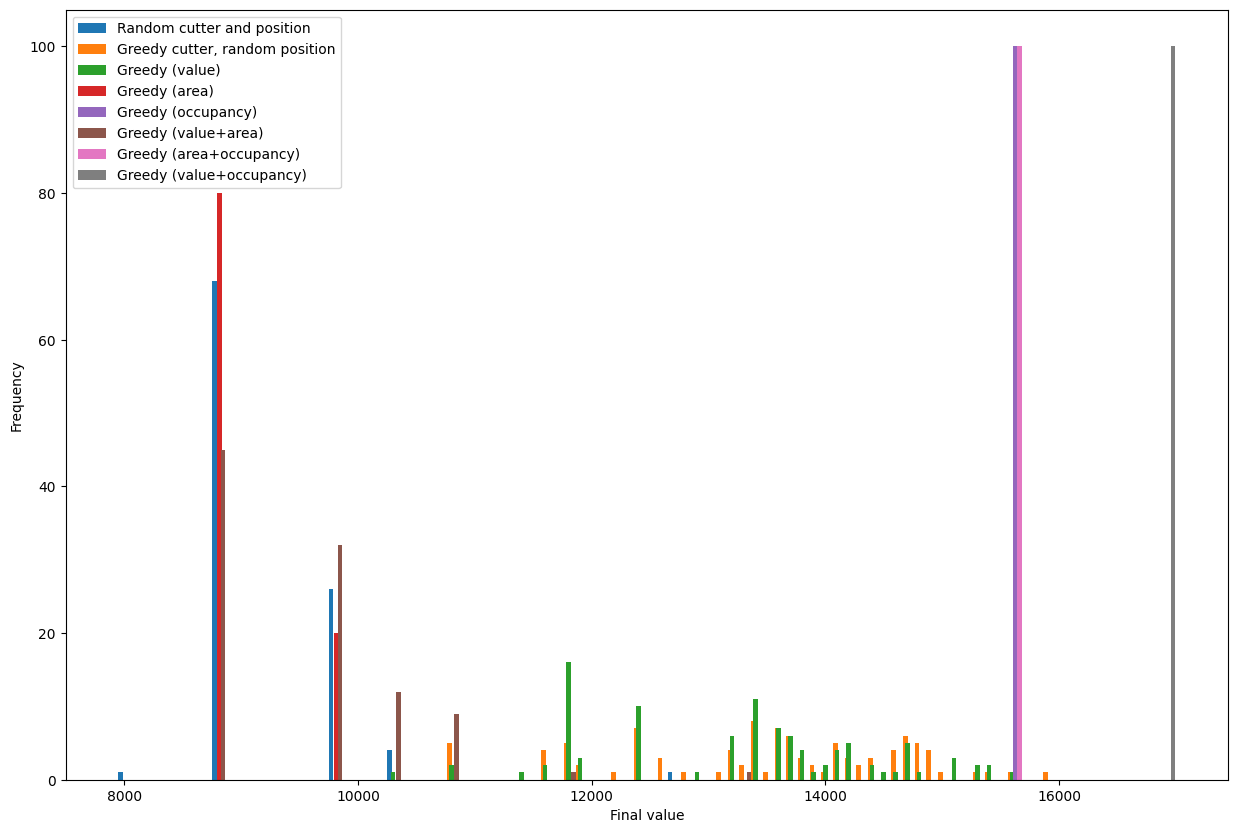

{'Greedy (area)': {8800: 80, 9800: 20},
 'Greedy (area+occupancy)': {15600: 100},
 'Greedy (occupancy)': {15600: 100},
 'Greedy (value)': {10300: 1,
                    10800: 2,
                    11400: 1,
                    11600: 2,
                    11800: 16,
                    11900: 3,
                    12400: 10,
                    12900: 1,
                    13200: 6,
                    13400: 11,
                    13600: 7,
                    13700: 6,
                    13800: 4,
                    13900: 1,
                    14000: 2,
                    14100: 4,
                    14200: 5,
                    14400: 2,
                    14500: 1,
                    14600: 1,
                    14700: 5,
                    14800: 1,
                    15100: 3,
                    15300: 2,
                    15400: 2,
                    15600: 1},
 'Greedy (value+area)': {8800: 45,
                         9800: 32,
                         10

In [80]:
results_dict = {
	"Random cutter and position": random_dict,
	"Greedy cutter, random position": greedy_random_dict,
	"Greedy (value)": greedy_value_dict,
	"Greedy (area)": greedy_area_dict,
	"Greedy (occupancy)": greedy_occupancy_dict,
	"Greedy (value+area)": greedy_value_area_dict,
	"Greedy (area+occupancy)": greedy_area_occupancy_dict,
	"Greedy (value+occupancy)": greedy_value_occupancy_dict,
}
show_all_results(results_dict)
pprint(results_dict)

## Conclusions
Greedy heuristics with the defined cost maps were not enough to reach the Python models' solutions. The greedy value + occupancy strategy is the best among the experiments and will be kept for the next experiments.